##<font color='lightblue'>Intro</font>
This project is using monte carlo method for prediction of covid 19 trends.

The training data : Israel's new daily cases on 20.1.2022-20.3.2022

Target: Predicting the following 21 days (new daily cases) to the training data

Data origin: https://datadashboard.health.gov.il/COVID-19/general





##<font color='lightblue'>Imports</font>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import math
import random
import plotly.express as px

# from sklearn.linear_model import LinearRegression
# from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##<font color='lightblue'>Data preparetion</font>

In [ ]:
#load data
path = "/content/drive/MyDrive/git_projects/monte_carlo/data_for_mcmc_train_and_test_20_1_2022_to_10_4_2022.csv"
df = pd.read_csv(path)
df['new_previous_date']=df.new_daily.shift(1) # take the values (new caes) from the day before
df=df.fillna(value=df['new_daily'].iloc[0]) # for the first data point use the same value as current date
df['log_new_previous_date'] = df.apply(lambda row: np.log(row['new_previous_date']), axis=1) # log on the values from the day before

#split train/test
split_date ='2022-03-21'
df_train = df.loc[df['date'] < split_date]
df_test = df.loc[df['date'] >= split_date]

#add previous date caes and log previous date, split X and y for train
X = df_train[['new_previous_date', 'log_new_previous_date']].values
y= df_train['new_daily'].values
X_y = df_train[['new_previous_date', 'log_new_previous_date', 'new_daily']].values
#Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler() 
X_y_scaled = scaler.fit_transform(X_y)
X = X_y_scaled[:,:-1]
y = X_y_scaled[:,-1]

df.head() #present original data

,date,new_daily,new_previous_date,log_new_previous_date
0,2022-01-20,75109,75109.0,11.226696
1,2022-01-21,65633,75109.0,11.226696
2,2022-01-22,67937,65633.0,11.091834
3,2022-01-23,85248,67937.0,11.126336
4,2022-01-24,83734,85248.0,11.353320


In [ ]:
#plot original data
fig = px.scatter(df, x='date', y='new_daily',color_discrete_sequence=px.colors.qualitative.Pastel,title=" Israel's new daily covid19 cases on 20.1.2022-10.4.2022")
fig.add_vline(x="2022-03-21", line_width=3, line_dash="dash", line_color="green")
fig.add_vrect(x0="2022-03-21", x1="2022-04-10", line_width=0, fillcolor="green", opacity=0.1,annotation_text="test data", annotation_position="top left")

fig.show()

#<font color='lightblue'>Monte Carlo</font>
The goal is to identify posterior distribution of model
parameters (using metropolis hasting algo)

##<font color='lightblue'>Monte Carlo - functions </font>

In [ ]:
def set_global_vars_for_mcmc_metropolis_hasting(num_params):
  # Prior: multivariate normal distribution with 0 mean and 1 cov
  # Likelihood: normal distribution Y|theta ~ N(y_pred, std_err)
  iters = 12500
  burn_in_period =2000
  tuning_period = 500
  P=0.25
  gamma = 2.4 / num_params
  prior_mu = []
  for i in range(num_params):
    prior_mu.append(1.0)
  prior_cov=np.identity(num_params)
  p_cov=np.identity(3)/1000
  thetas_starting_point_arrays = [np.random.randint(0,[1,2,3]).astype("float"), np.random.randint(5,[6,6,6]).astype("float"), np.random.randint([1,2,3],[3,6,9]).astype("float")]
  return iters,burn_in_period,tuning_period,P,gamma,prior_mu,prior_cov,p_cov,thetas_starting_point_arrays
  

In [ ]:
def normal_log_like(params, X, y, std_eps):
    n = y.shape[0]
    y_pred = params[0] + params[1] * X[:,0] + params[2] * X[:,1]
    sum_err = ((y - y_pred) ** 2).sum()
    ll = -n * np.log(2*math.pi) / 2 - n*np.log(std_eps) - sum_err / (2*(std_eps**2))
#     print(ll)
    return ll

In [ ]:
def metropolis_hasting(X, y, cur_thtas, prior_mu, prior_cov, gamma, p_cov, ar_star=0.4, std_err=0.1):
    thetas = []
    acceptance_rates = []
    accepted_counter = 0

    for i in range(1, iters):
        thetas.append(cur_thtas)
        
        log_cur_posterior = np.log(multivariate_normal.pdf(cur_thtas, mean=prior_mu, cov=prior_cov)) + \
            normal_log_like(cur_thtas, X, y, std_err)
        suggested_thetas = np.random.multivariate_normal(mean=cur_thtas, cov=(gamma **2) * p_cov)
        log_new_posterior = np.log(multivariate_normal.pdf(suggested_thetas, mean=prior_mu, cov=prior_cov)) + \
            normal_log_like(suggested_thetas, X, y, std_err)
        
        r = min((log_new_posterior - log_cur_posterior),1)
        alpha = np.log(random.uniform(0, 1))
        if r > alpha: # if r>alpha replace the current thetas and add accepted case to the counter
          cur_thtas = suggested_thetas
          accepted_counter += 1
        # if alpha>=r then we don't need to do anything and we can continue in the algo

        acc_rate = accepted_counter / i
        acceptance_rates.append(acc_rate)

        if i <= burn_in_period and i % tuning_period == 0:
            prop_dist_cov = P * p_cov + (1-P) * np.cov(np.array(thetas), rowvar=False)
            gamma = gamma * np.exp((acc_rate - ar_star) / i)

    
    return thetas, acceptance_rates

In [ ]:
def plot_acceptance_rate(acceptance_rates,c,starting_point_number):
    plt.plot(range(1, iters), acceptance_rates,color=c)
    plt.title(f'Acceptance rate per iteration, \n starting point number {starting_point_number}')
    plt.xlabel('Iteration')
    plt.ylabel('Acceptance rate')
    plt.rcParams["figure.figsize"] = (10,5)
    plt.show()

In [ ]:
def plot_param_chains(num_params, params,c,starting_point_number):
    fig, axs = plt.subplots(1, num_params, figsize=(11, 3),sharey=True, tight_layout=False)
    for i in range(num_params): #create different graph for each theta
        theta = [thetas[i] for thetas in params[burn_in_period:]]
        #axs[i].figure()
        axs[i].plot(range(burn_in_period, iters -1), theta,color=c)
        axs[i].set_title(f'theta {i} Trace plot, \n starting point number {starting_point_number}', fontsize=12)
        axs[i].set(xlabel='iter',ylabel=f'theta_{i} value')     

In [ ]:
def plot_posterior(num_params, params,c,starting_point_number):
    fig, axs = plt.subplots(1, num_params, figsize=(11, 3),sharey=True, tight_layout=False)
    for i in range(num_params):
        theta = [thetas[i] for thetas in params[burn_in_period:]]
        axs[i].hist(theta, bins=500,color=c)
        axs[i].set_title(f'theta {i} Posterior distribution, \n starting point number {starting_point_number}', fontsize=12)

In [ ]:
def gelman_rubin_test(chains_means, chains_vars, M, N):
    chains_mean = np.array(chains_means).mean(axis=0)
    B = (N / (M - 1)) * np.sum((np.array(chains_means) - chains_mean)**2, axis=0)
    W = np.array(chains_vars).mean(axis=0)
    v_tag = ((N - 1) / N) * W + ((M + 1) / (N * M)) * B
    R=np.sqrt(v_tag / W) # we aim for the ratio between the varience within each chain and the variences bwtween the chains to be 1 (no big difernce)
    return R

##<font color='lightblue'>Monte Carlo - fit train data</font>


###<font color='lightblue'>Create global veriables</font>

In [ ]:
# Global variabels 
num_params=X.shape[1]+1 # +1 is for y var
iters,burn_in_period,tuning_period,P,gamma,prior_mu,prior_cov,p_cov,thetas_starting_point_arrays=set_global_vars_for_mcmc_metropolis_hasting(num_params)

###<font color='lightblue'>Run model and examine it using visualisations </font>

* Acceptance rate - should stable on low value after the burn-in period


* Trace plots, for each starting point and parameter - 
if all the parameters converged to the same range of values (from different starting points) then our thetas’ estimation is good and the algorithm has converged.

* Posterior distribution, for each starting point and parameter - All the parameters’ posterior distribution should resemble the normal distribution, each parameter with similar mean and variance in all starting points (but each parameter with its own values of mean and variance).



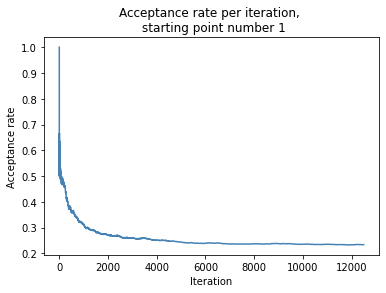

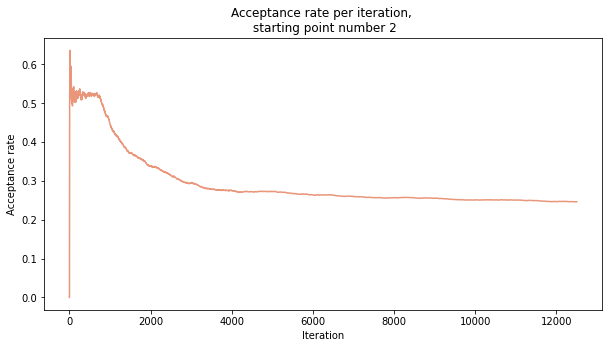

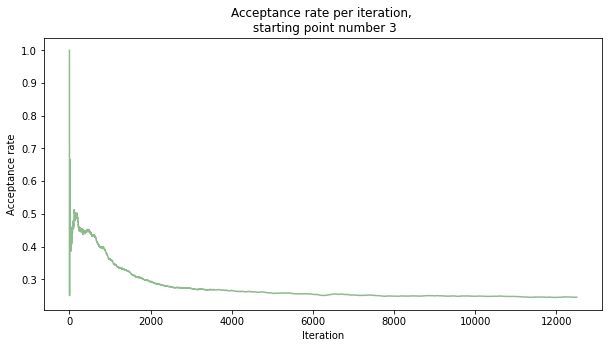

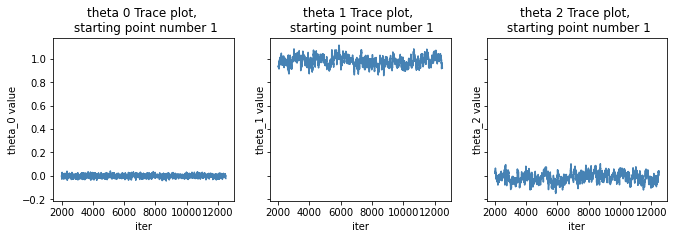

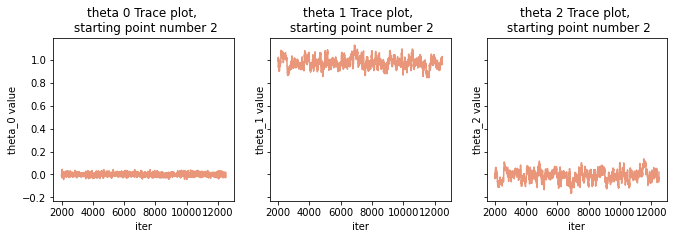

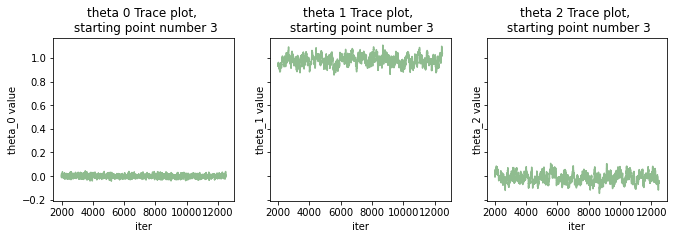

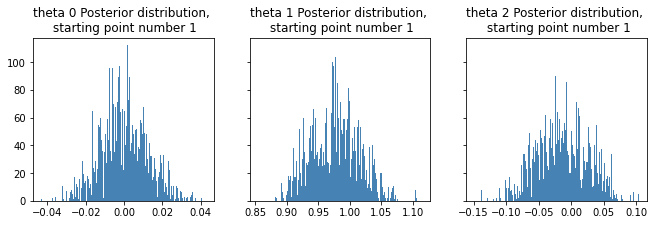

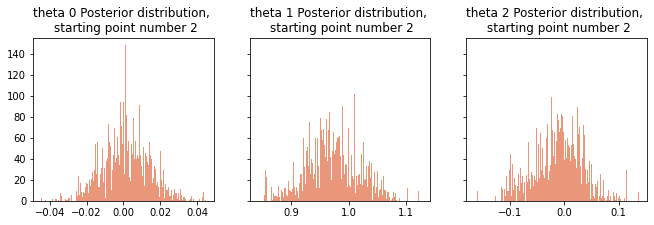

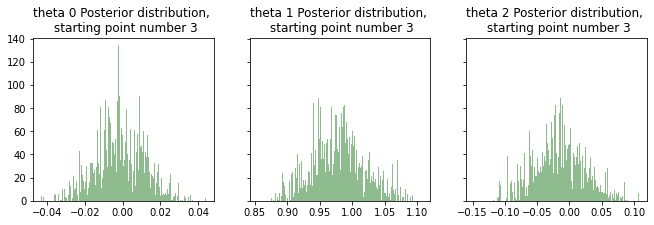

In [ ]:
# Running the metropolis hasting from 3 different starting points
# Ploting each starting point in a different color
chains_means = []
chains_vars = []

params_starting_points=[]
acceptance_rate_starting_points=[]

for starting_points_array in thetas_starting_point_arrays:
    params, acceptance_rates = metropolis_hasting(X, y, starting_points_array, prior_mu, prior_cov, gamma, p_cov)
    param_means = np.array(params).mean(axis=0)
    param_vars = np.array(params).var(axis=0)
    chains_means.append(param_means)
    chains_vars.append(param_vars)
    acceptance_rate_starting_points.append(acceptance_rates)
    params_starting_points.append(params)

colors=['steelblue','darksalmon','darkseagreen']
j=0
for acceptance_rates in acceptance_rate_starting_points:
    plot_acceptance_rate(acceptance_rates,colors[j],j+1)
    j=j+1
j=0
for params in params_starting_points:
    plot_param_chains(num_params, params,colors[j],j+1)
    j=j+1
j=0
for params in params_starting_points:
    plot_posterior(num_params, params,colors[j],j+1)
    j=j+1

###<font color='lightblue'>Gelman Rubin test</font>
The Gelman-Rubin test is based on multiple independent chains.

The variances within each chain are compared to the variances between the chains.
A large deviation between these two variances indicates non-convergence.

If all the ratios between the chains’ variances of within and between are ~1 then the model converged.

In [ ]:
test_results_array=gelman_rubin_test(chains_means, chains_vars, len(thetas_starting_point_arrays), len(params))
test_results_df = pd.DataFrame({'Chain number': [1, 2 ,3], 'Gelman Rubin test results': test_results_array})
print("The test results: \n")
print(test_results_df.to_string(index=False))


The test results: 

 Chain number  Gelman Rubin test results
            1                   1.024444
            2                   1.017229
            3                   1.013799


#<font color='lightblue'>Predict</font>

##<font color='lightblue'>Prep test data</font>

In [ ]:
#add previous date caes and log previous date, split X and y for train
X_test = df_test[['new_previous_date', 'log_new_previous_date']].values
y_test= df_test['new_daily'].values

##<font color='lightblue'>Predict and present prediction vs real data</font>

1.   Sample params from distrabution
2.   Find the best model (The one to minimize the error between predictions and true data, meaning the one to maximize the log likelihood function)
3.   Plot predicted vs real data

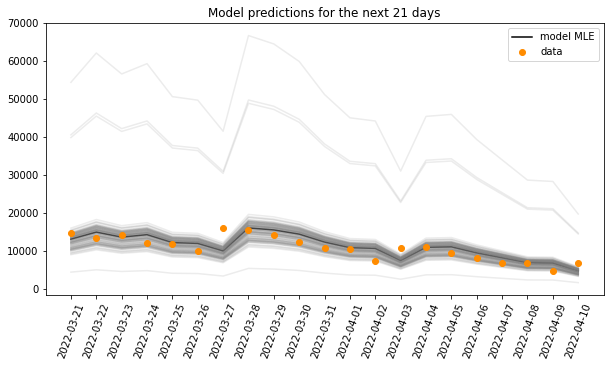

In [ ]:
# Estimatation of posterior distribution out of the posterior parameters instances
kde = stats.gaussian_kde(np.array(params_starting_points[1]).transpose()) #choosing starting point number 2 (randomly, all should provide similar results)
resample_params = kde.resample(size=100).transpose() # 100 samples for params

# Choosing params based max log like on train data (first given 60 days)
log_likes = []
y_preds = []
for param_set in resample_params:
    log_likes.append(normal_log_like(param_set, X, y, 0.1)) #calc log like based on train
    future_y_pred = param_set[0] + param_set[1] * X_test[:,0] + param_set[2] * X_test[:,1] #calc prediction for all data points
    y_preds.append(future_y_pred)
    
best_realization = np.argmax(np.array(log_likes)) #prediction that maximize log likelihood

# Plot prediction vs real data
for realiztion in range(len(y_preds)):
    if realiztion == best_realization: # if it's the index of the max log likelihood (best realization) then use black mark
        c = 'black'
        alpha = 1
        label = 'model MLE'
        
    else:
        c = 'gray'
        alpha = 0.15
        label = None
    plt.plot(df_test['date'], y_preds[realiztion],'-',c=c, alpha=alpha, label=label)

# Add real data to the plot
plt.plot(df_test['date'], y_test,'o', c='darkorange', label='data')
plt.xticks(rotation=70)
plt.legend()
plt.title('Model predictions for the next 21 days')
plt.show()

In [ ]:
df_summary=pd.DataFrame({"data":df_test['date'].values,"real data":y_test,"predicted data":y_preds[best_realization]})
print(df_summary.to_string(index=False))

      data  real data  predicted data
2022-03-21      14769    13050.439320
2022-03-22      13455    14905.448443
2022-03-23      14101    13579.288445
2022-03-24      12033    14231.266619
2022-03-25      11812    12144.129281
2022-03-26       9860    11921.084182
2022-03-27      15865     9951.021129
2022-03-28      15337    16011.591191
2022-03-29      14239    15478.704887
2022-03-30      12164    14370.543698
2022-03-31      10704    12276.341539
2022-04-01      10504    10802.831072
2022-04-02       7362    10600.980359
2022-04-03      10794     7429.907214
2022-04-04      10918    10893.663896
2022-04-05       9340    11018.811346
2022-04-06       8065     9426.209410
2022-04-07       6796     8139.411813
2022-04-08       6712     6858.670398
2022-04-09       4668     6773.893218
2022-04-10       6747     4710.983428
